In [129]:
from __future__ import division, print_function

import os
from datetime import datetime

# Ignore warnings
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from skimage import io, transform
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
from sklearn.metrics import average_precision_score, accuracy_score

warnings.filterwarnings("ignore")


import copy
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, models, transforms
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import random
import albumentations as A
from math import ceil
from collections import Counter

In [181]:
# import sys
# sys.path.append("../")

# %load_ext autoreload
# %autoreload 2

### Prepare data

In [133]:
dataset = torchvision.datasets.ImageFolder(root="../data/chest_xray", 
                                 transform = None,
                                 target_transform = None,
                                 )

In [134]:
len(dataset)

5856

In [137]:
Counter(dataset.targets)

Counter({0: 1583, 1: 4273})

In [70]:
def visualize_classes(dataset: Dataset, classes: list = [0, 1], columns: int = 6, inv_normalize = None):
    np.random.seed(0)
    classes_ids = [[] for _ in range(len(classes))]
    for i, class_ in enumerate(classes):
        for _ in range(columns):
            id_ = np.random.randint(len(dataset), size=1)[0]
            while dataset[id_][1] != class_:
                id_ = np.random.randint(len(dataset), size=1)[0]
            classes_ids[i].append(id_)
    f, ax = plt.subplots(len(classes), columns)
    f.set_size_inches(18.5, 10.5)
    for i in range(len(classes)):
        for j in range(columns):
            ax[i, j].set_title(f"id - {classes_ids[i][j]}; label - {dataset[classes_ids[i][j]][1]}")
            image = dataset[classes_ids[i][j]][0]
            if inv_normalize is not None:
                image = inv_normalize(image)
            if isinstance(image, torch.Tensor):
                image = image.permute(1, 2, 0).numpy()
            ax[i, j].imshow(image)
            ax[i, j].axis('off')

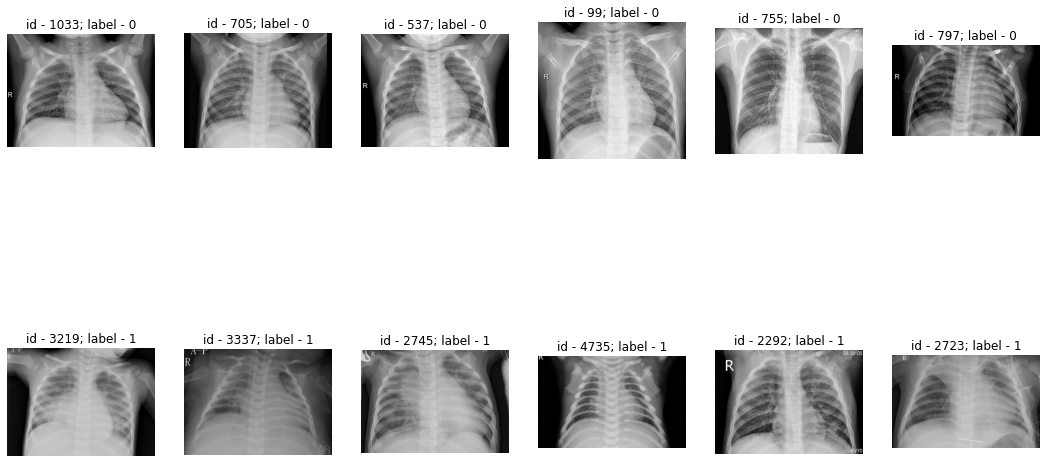

In [71]:
visualize_classes(dataset)

In [72]:
dataset = torchvision.datasets.ImageFolder(
    root="../data/chest_xray", 
    transform = transforms.Compose(
        [
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    ),
    target_transform = None,
)

In [73]:
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.255]
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


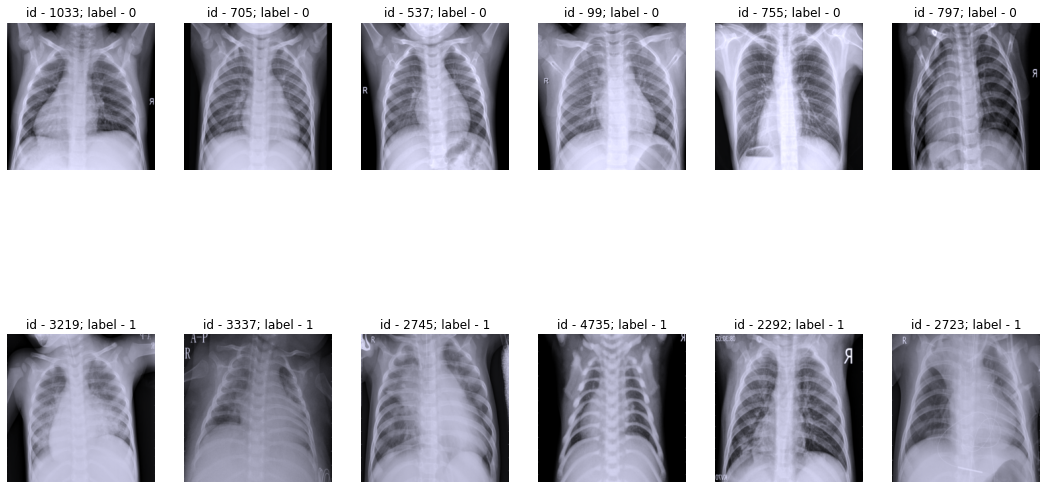

In [74]:
visualize_classes(dataset, inv_normalize=inv_normalize)

In [75]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size], torch.Generator().manual_seed(0)
)

In [76]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True, num_workers=2
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=True, num_workers=2
)

In [105]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

### Train model

In [78]:
def epoch(loader, model, device, criterion, opt=None):
    probabilities = []
    all_labels = []
    total_loss = 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        if opt:
            opt.zero_grad()
            loss.backward()
            opt.step()

        total_loss += loss.item() * inputs.size(0)
        all_labels.extend(list(labels.cpu().detach().numpy().reshape(-1)))
        probabilities.extend(list(outputs.cpu().detach().numpy()[:, 1].reshape(-1)))
    return total_loss / float(len(loader.dataset)), all_labels, probabilities

In [79]:
def print_metrics(writer, phase, epoch_num, loss, labels, prob, lr=None):
    acc = accuracy_score(labels, (np.array(prob) > 0.5).astype(int))
    ap = average_precision_score(labels, prob)

    writer.add_scalar(f'Loss/{phase}', loss, epoch_num)
    writer.add_scalar(f'Accuracy/{phase}', acc, epoch_num)
    writer.add_scalar(f'Average precision/{phase}', ap, epoch_num)
    if lr is not None:
        writer.add_scalar(f'LR/{phase}', lr, epoch_num)
        print(f"{phase} Loss: {loss:.4f} Acc: {acc:.4f} AP: {ap:.4f} LR: {lr}")
    else:
        print(f"{phase} Loss: {loss:.4f} Acc: {acc:.4f} AP: {ap:.4f}")

In [122]:
def create_writers(log_dir: str = "./runs"):
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    train_log_dir = log_dir + current_time + "/train"
    val_log_dir = log_dir + current_time + "/val"
    train_writer = SummaryWriter(log_dir=train_log_dir)
    val_writer = SummaryWriter(log_dir=val_log_dir)
    return train_writer, val_writer

In [123]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 100.0
    best_epoch = 0
    train_writer, val_writer = create_writers("../runs")
    model.train()

    for epoch_num in range(num_epochs):
        print(f"Epoch {epoch_num}/{num_epochs - 1}")
        print("-" * 10)

        train_loss, train_labels, train_prob = epoch(train_loader, model, device, criterion, opt = optimizer)
        val_loss, val_labels, val_prob = epoch(test_loader, model, device, criterion)

        print_metrics(train_writer, "train", epoch_num, train_loss, train_labels, train_prob, optimizer.param_groups[0]["lr"])
        print_metrics(val_writer, "val", epoch_num, val_loss, val_labels, val_prob)

        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_epoch = epoch_num
            best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val loss: {best_loss:4f} Best epoch: {best_epoch}")

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [124]:
device = "cuda:0"
# device = "cpu"

In [99]:
model_ft = models.resnet18(pretrained=True)

model_ft.fc = nn.Sequential(
    nn.Linear(model_ft.fc.in_features, 2),
    nn.Softmax(),
)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001, weight_decay=0.001)

exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, 'min', patience=5, eps=1e-07)

In [100]:
model_ft = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=15
)

Epoch 0/14
----------
train Loss: 0.3998 Acc: 0.9095 AP: 0.9789 LR: 0.001
val Loss: 0.4010 Acc: 0.9087 AP: 0.9776

Epoch 1/14
----------
train Loss: 0.3806 Acc: 0.9304 AP: 0.9830 LR: 0.001
val Loss: 0.3842 Acc: 0.9275 AP: 0.9844

Epoch 2/14
----------
train Loss: 0.3812 Acc: 0.9313 AP: 0.9789 LR: 0.001
val Loss: 0.3664 Acc: 0.9437 AP: 0.9899

Epoch 3/14
----------
train Loss: 0.3930 Acc: 0.9184 AP: 0.9822 LR: 0.001
val Loss: 0.3885 Acc: 0.9232 AP: 0.9810

Epoch 4/14
----------
train Loss: 0.3898 Acc: 0.9208 AP: 0.9727 LR: 0.001
val Loss: 0.3894 Acc: 0.9181 AP: 0.9838

Epoch 5/14
----------
train Loss: 0.3776 Acc: 0.9345 AP: 0.9860 LR: 0.001
val Loss: 0.4006 Acc: 0.9053 AP: 0.9806

Epoch 6/14
----------
train Loss: 0.3836 Acc: 0.9263 AP: 0.9822 LR: 0.001
val Loss: 0.4005 Acc: 0.9104 AP: 0.9800

Epoch 7/14
----------
train Loss: 0.3743 Acc: 0.9379 AP: 0.9841 LR: 0.001
val Loss: 0.3881 Acc: 0.9241 AP: 0.9831

Epoch 8/14
----------
train Loss: 0.3798 Acc: 0.9302 AP: 0.9829 LR: 0.001
val Lo

### Analyze results

In [106]:
val_image = []
val_true = []
val_pred = []
val_prob = []
model_ft.eval()
with torch.no_grad():
    for inputs, batch_labels in tqdm(test_loader):
        inputs = inputs.to("cuda:0")
        outputs = model_ft(inputs)
        prob = outputs.to("cpu").numpy()[:, 1]
        preds = (prob > 0.5).astype(int)
        val_prob.extend(prob)
        val_pred.extend(preds)
        val_true.extend(batch_labels.to("cpu").numpy())
        val_image.extend(inputs.to("cpu"))

100%|██████████| 37/37 [00:06<00:00,  6.02it/s]


In [107]:
def error_class(row):
    if row["true"] == row["pred"] == 1:
        return "TP"
    elif row["true"] == row["pred"] == 0:
        return "TN"
    elif row["true"] != row["pred"] and row["pred"] == 1:
        return "FP"
    else:
        return "FN"

In [108]:
df = pd.DataFrame({"true": val_true, "pred": val_pred, "prob": val_prob})

In [109]:
df["error_type"] = df.apply(error_class, axis=1)

In [110]:
df.groupby("error_type").count()

,true,pred,prob
error_type,,,
FN,15,15,15
FP,28,28,28
TN,279,279,279
TP,850,850,850


In [112]:
print(f"accuracy_score - {accuracy_score(df['true'], df['pred'])}")
print(f"average_precision_score - {average_precision_score(df['true'], df['pred'])}")

accuracy_score - 0.9633105802047781
average_precision_score - 0.9641199509933077


In [170]:
n = 10
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.255]
)
def view_images(df: pd.DataFrame, images: np.ndarray, columns: int = 5, fig_size: tuple = (18.5, 10.5)):
    f, ax = plt.subplots(ceil(df.shape[0] / columns), columns)
    f.set_size_inches(*fig_size)
    for i, (id_, row) in enumerate(df.iterrows()):
        if ax.ndim  == 2:
            current_ax = ax[i // columns, i % columns]
        else:
            current_ax = ax[i]
        current_ax.set_title(str(row))
        current_ax.imshow(inv_normalize(images[id_]).permute(1, 2, 0).numpy())
        current_ax.axis('off')

In [171]:
df

,true,pred,prob,error_type
0,1,1,9.784760e-01,TP
1,1,1,9.999765e-01,TP
2,1,1,9.998493e-01,TP
3,1,1,9.999796e-01,TP
4,1,1,9.999502e-01,TP
...,...,...,...,...
1167,0,0,7.549995e-12,TN
1168,1,1,9.998220e-01,TP
1169,1,1,9.999884e-01,TP
1170,1,1,9.999855e-01,TP


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


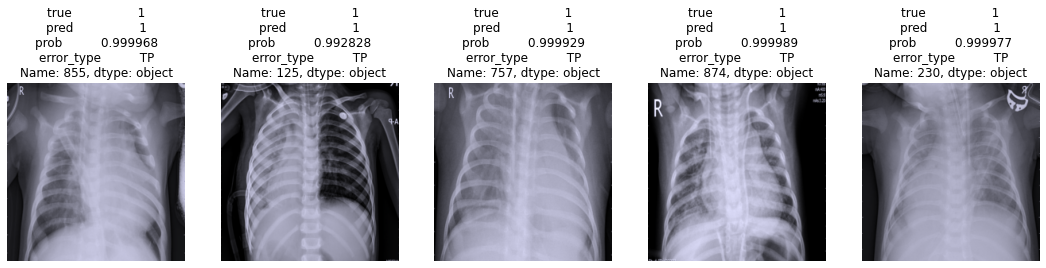

In [173]:
view_images(df[df["error_type"]=="TP"].sample(5), val_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


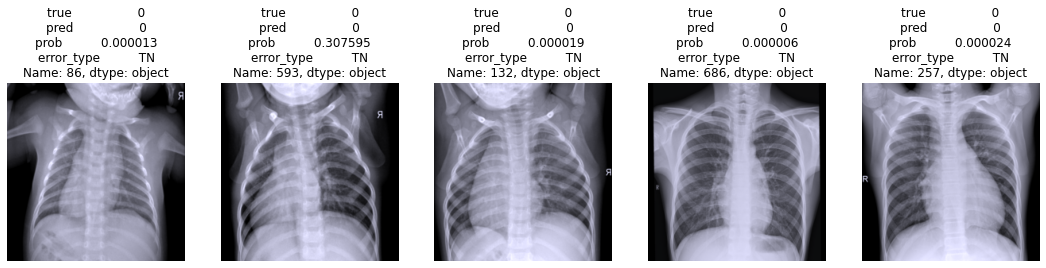

In [175]:
view_images(df[df["error_type"]=="TN"].sample(5), val_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


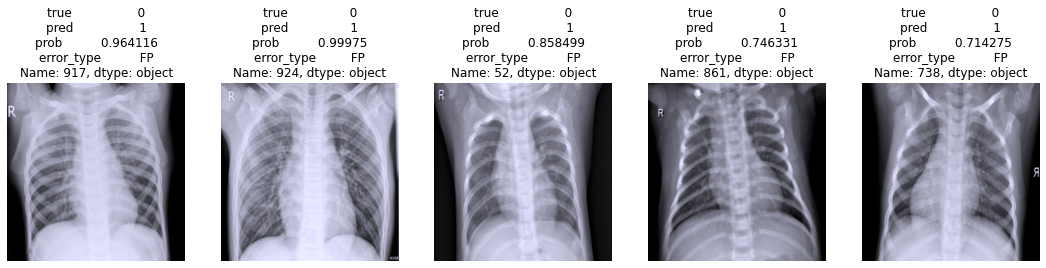

In [176]:
view_images(df[df["error_type"]=="FP"].sample(5), val_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


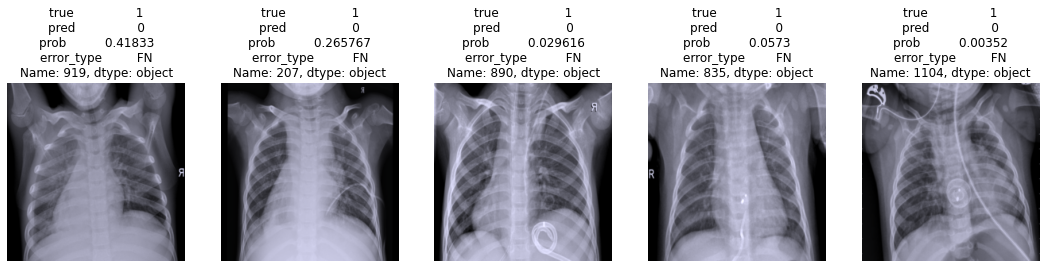

In [177]:
view_images(df[df["error_type"]=="FN"].sample(5), val_image)

### Save model

In [179]:
save_path = f"../models/resnet18_{datetime.now().strftime('%Y-%m-%d_%H:%M:%S')}.pt"
torch.save(model_ft.state_dict(), save_path)
save_path

'../models/resnet18_2021-04-11_20:47:32.pt'

In [180]:
model = models.resnet18()
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 2),
    nn.Softmax(),
)

model.load_state_dict(torch.load(save_path))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  